# Baseline_KJY

## Loading Data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time

import pylab as plot

# 행 많이보기
pd.set_option('display.max_row',40)
pd.set_option('display.max_columns', 100)

# 한글 폰트 설정
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
plt.rc('font', size=12)
plt.figure(figsize=(20,10))

# 지수 표현 안보기

# 데이터 로드
data = pd.read_excel('./Data/2019_data_time.xlsx', encoding='cp949', header=0, parse_dates=["방송일시"])

# 무형 제거

data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)



# 판매단가, 취급액 쉼표 제거 , int 변환

# data['판매단가'] = data['판매단가'].str.replace(',','').astype(int)
# data['취급액'] = data['취급액'].str.replace(',','').astype(int)
# data['노출(분)'] = data['노출(분)'].astype(int)



# 취급액 결측치 값 변경
# df.loc[df['취급액']==1]['취급액'] = 50000



# 날짜 변경 ( 다음날 데이터를 현재 날짜로 할 건지 )




# data 의 colname 영어로 변경
# index drop 필요
print(data.columns)
data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']
print(data.columns)
                
# M', 'D', 'day', 'H', 'm',
#3

Index(['index', '방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object')
Index(['index', 'time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT'],
      dtype='object')


<Figure size 1440x720 with 0 Axes>

# 전처리

## time feature

In [2]:
data['time_month']    = data['time'].dt.month        # 월(숫자)
data['time_day']        = data['time'].dt.day          # 일(숫자)
data['time_hour']       = data['time'].dt.hour         # 시(숫자)
data['time_minute']     = data['time'].dt.minute       # 분(숫자)
data['weekofyear']    = data['time'].dt.weekofyear      # 연 기준 몇주째(숫자) (=week)
data['dayofyear']     = data['time'].dt.dayofyear       # 연 기준 몇일째(숫자)
data["day_of_the_week"] = data["time"].dt.dayofweek
data['date']        = data['time'].dt.date          # 년월일

In [3]:
# 홈쇼핑 하루 방송 사이클이 오전 06시(06시20분)~익일 02시(02시20분) 까지 이므로 날짜를 맞춰주는 작업 수행
# 0시~3시 사이의 방송시간을 24시~27시로 변경
# 방송 날짜와 요일을 하루전으로 변경
overnight_index_list = data.loc[(data["time_hour"] >=0) & (data["time_hour"] < 3)].index
overnight_index_list
data.loc[overnight_index_list, "time_hour"] += 24
data.loc[overnight_index_list, "time_day"] -= 1
data.loc[overnight_index_list, "dayofyear"] -= 1
data.loc[overnight_index_list, "day_of_the_week"] -= 1
data.loc[data["day_of_the_week"] == -1, "day_of_the_week"] = 6

In [4]:
# 다음달로 넘어가거나 다음연도로 넘어간 항목은 월,일 재조정
data.loc[(data["time_month"] == 2) & (data["time_day"] == 0), ["time_month", "time_day"]] = 1, 31
data.loc[(data["time_month"] == 3) & (data["time_day"] == 0), ["time_month", "time_day"]] = 2, 28
data.loc[(data["time_month"] == 4) & (data["time_day"] == 0), ["time_month", "time_day"]] = 3, 31
data.loc[(data["time_month"] == 5) & (data["time_day"] == 0), ["time_month", "time_day"]] = 4, 30
data.loc[(data["time_month"] == 6) & (data["time_day"] == 0), ["time_month", "time_day"]] = 5, 31
data.loc[(data["time_month"] == 7) & (data["time_day"] == 0), ["time_month", "time_day"]] = 6, 30
data.loc[(data["time_month"] == 8) & (data["time_day"] == 0), ["time_month", "time_day"]] = 7, 31
data.loc[(data["time_month"] == 9) & (data["time_day"] == 0), ["time_month", "time_day"]] = 8, 31
data.loc[(data["time_month"] == 10) & (data["time_day"] == 0), ["time_month", "time_day"]] = 9, 30
data.loc[(data["time_month"] == 11) & (data["time_day"] == 0), ["time_month", "time_day"]] = 10, 31
data.loc[(data["time_month"] == 12) & (data["time_day"] == 0), ["time_month", "time_day"]] = 11, 30
data.loc[(data["time_month"] == 1) & (data["time_day"] == 0), ["time_month", "time_day"]] = 12, 31

In [5]:
data[-4:]['dayofyear'] = 365

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 기상 feature 추가 (지역별 인구수에 가중치 부여)

### 데이터 불러오기

In [6]:
# 지역별 데이터 불러오기
seoul_df = pd.read_csv('./Data/서울.csv', encoding = 'euc-kr')
busan_df = pd.read_csv('./Data/부산.csv', encoding = 'euc-kr')
inchon_df = pd.read_csv('./Data/인천.csv', encoding = 'euc-kr')
daeseon_df = pd.read_csv('./Data/대전.csv', encoding = 'euc-kr')
daegu_df = pd.read_csv('./Data/대구.csv', encoding = 'euc-kr')
ulsan_df = pd.read_csv('./Data/울산.csv', encoding = 'euc-kr')
gwangzu_df = pd.read_csv('./Data/광주.csv', encoding = 'euc-kr')

# 지역별 인구수
seoul = 9729107
busan = 3413841
inchon = 2957026
daeseon = 1474870
daegu = 2438031
ulsan = 1148019
gwangzu = 1456468

# 지역별 인구수 합
total = seoul+busan+inchon+daeseon+ulsan+seoul+gwangzu

# 지역별 인구수 비율
seoul_rate = seoul/total
busan_rate = busan/total
inchon_rate = inchon/total
daeseon_rate = daeseon/total
daegu_rate = daegu/total
ulsan_rate = ulsan/total
gwangzu_rate = gwangzu/total

# 결측값 처리
seoul_df.fillna(0, inplace = True)
busan_df.fillna(0, inplace = True)
inchon_df.fillna(0, inplace = True)
daeseon_df.fillna(0, inplace = True)
daegu_df.fillna(0, inplace = True)
ulsan_df.fillna(0, inplace = True)
gwangzu_df.fillna(0, inplace = True)

# 비율 반영

seoul_df2 = seoul_df.drop(['일시','지점','지점명'],axis = 1)*seoul_rate
busan_df2 = busan_df.drop(['일시','지점','지점명'],axis = 1)*busan_rate 
inchon_df2 = inchon_df.drop(['일시','지점','지점명'],axis = 1)*inchon_rate
daeseon_df2 = daeseon_df.drop(['일시','지점','지점명'],axis = 1)*daeseon_rate
daegu_df2 = daegu_df.drop(['일시','지점','지점명'],axis = 1)*daegu_rate
ulsan_df2 = ulsan_df.drop(['일시','지점','지점명'],axis = 1)*ulsan_rate
gwangzu_df2 = gwangzu_df.drop(['일시','지점','지점명'],axis = 1)*gwangzu_rate

# 데이터 프레임 병합

#r_df = seoul_df2 + busan_df2 + inchon_df2 + daeseon_df2 + daegu_df2 + ulsan_df2 + gwangzu_df2 
r_df = seoul_df.drop(['일시','지점','지점명'],axis = 1)
r_df['date'] = seoul_df['일시']
r_df['date'] = pd.to_datetime(r_df['date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
r_df['dayofyear'] = r_df['date'].dt.dayofyear
r_df.drop(['일 최심신적설(cm)','최대 순간 풍속(m/s)'],axis = 1 ,inplace = True)
r_df.drop(365, inplace = True)
r_df

,평균기온(°C),최저기온(°C),최고기온(°C),강수 계속시간(hr),1시간 최다강수량(mm),일강수량(mm),최대 풍속(m/s),평균 풍속(m/s),최소 상대습도(%),평균 상대습도(%),date,dayofyear
0,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,1
1,-4.9,-8.8,0.2,0.00,0.0,0.0,3.6,1.7,20,42.8,2019-01-02,2
2,-3.5,-8.4,3.2,0.00,0.0,0.0,2.9,1.4,18,38.8,2019-01-03,3
3,-1.1,-6.2,4.1,0.00,0.0,0.0,3.0,1.2,34,55.5,2019-01-04,4
4,-2.8,-5.5,1.1,0.00,0.0,0.0,4.3,2.2,20,40.3,2019-01-05,5
...,...,...,...,...,...,...,...,...,...,...,...,...
360,-1.7,-4.6,2.6,0.00,0.0,0.0,4.3,2.1,23,45.4,2019-12-27,361
361,1.1,-3.6,6.1,0.00,0.0,0.0,3.7,2.0,34,47.6,2019-12-28,362
362,3.8,1.1,6.2,6.75,0.0,1.4,4.4,2.9,37,52.5,2019-12-29,363
363,2.7,-5.7,6.8,5.08,0.0,0.4,7.4,2.9,43,70.3,2019-12-30,364


### Reindexing

In [7]:
r_df.columns = ['mean_temp','min_temp','max_temp','raining_dur(hr)','rain_per_hour','rain_per_day','max_wind',
             'mean_wind','min_Humidity','mean_Humidity','date','dayofyear']

### DataFrame 병합

In [8]:
data = pd.merge(data,r_df,on = 'dayofyear', how='left')

In [9]:
data

,index,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,time_month,time_day,time_hour,time_minute,weekofyear,dayofyear,day_of_the_week,date_x,mean_temp,min_temp,max_temp,raining_dur(hr),rain_per_hour,rain_per_day,max_wind,mean_wind,min_Humidity,mean_Humidity,date_y
0,0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
1,1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
2,2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
3,3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
4,4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,1,1,6,40,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,38299,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,12,31,23,40,1,365,1,2019-12-31,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
37368,38300,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
37369,38301,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
37370,38302,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31


## 상품군 category 별 분류

In [10]:
# 카테고리명 영어로 변경
data.loc[data["category"] == "의류", "category"] = "clothes"
data.loc[data["category"] == "속옷", "category"] = "underwear"
data.loc[data["category"] == "주방", "category"] = "kitchen"
data.loc[data["category"] == "농수축", "category"] = "food"
data.loc[data["category"] == "이미용", "category"] = "beauty"
data.loc[data["category"] == "가전", "category"] = "electronics"
data.loc[data["category"] == "생활용품", "category"] = "necessaries"
data.loc[data["category"] == "건강기능", "category"] = "health"
data.loc[data["category"] == "잡화", "category"] = "goods"
data.loc[data["category"] == "가구", "category"] = "furniture"
data.loc[data["category"] == "침구", "category"] = "bedding"


In [11]:
# 상품군 one-hot encoding
data_dummy = pd.get_dummies(data, columns=['category'], prefix='category', drop_first=True)
data_dummy.drop(columns=['index','time','product_name','product_code'],inplace=True)



In [12]:
data_dummy

,exposure_time,mcode,price,salesAMT,time_month,time_day,time_hour,time_minute,weekofyear,dayofyear,day_of_the_week,date_x,mean_temp,min_temp,max_temp,raining_dur(hr),rain_per_hour,rain_per_day,max_wind,mean_wind,min_Humidity,mean_Humidity,date_y,category_bedding,category_clothes,category_electronics,category_food,category_furniture,category_goods,category_health,category_kitchen,category_necessaries,category_underwear
0,20.0,100346,39900,2099000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
1,20.0,100346,39900,4371000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
2,20.0,100346,39900,3262000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
3,20.0,100346,39900,6955000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
4,20.0,100346,39900,6672000.0,1,1,6,40,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,20.0,100448,148000,10157000.0,12,31,23,40,1,365,1,2019-12-31,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0
37368,20.0,100448,178000,50929000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0
37369,20.0,100448,168000,104392000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0
37370,20.0,100448,158000,13765000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0


## 주말 Feature 생성

In [13]:
data_dummy

,exposure_time,mcode,price,salesAMT,time_month,time_day,time_hour,time_minute,weekofyear,dayofyear,day_of_the_week,date_x,mean_temp,min_temp,max_temp,raining_dur(hr),rain_per_hour,rain_per_day,max_wind,mean_wind,min_Humidity,mean_Humidity,date_y,category_bedding,category_clothes,category_electronics,category_food,category_furniture,category_goods,category_health,category_kitchen,category_necessaries,category_underwear
0,20.0,100346,39900,2099000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
1,20.0,100346,39900,4371000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
2,20.0,100346,39900,3262000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
3,20.0,100346,39900,6955000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
4,20.0,100346,39900,6672000.0,1,1,6,40,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,20.0,100448,148000,10157000.0,12,31,23,40,1,365,1,2019-12-31,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0
37368,20.0,100448,178000,50929000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0
37369,20.0,100448,168000,104392000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0
37370,20.0,100448,158000,13765000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0


## Feature Correalation 확인

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


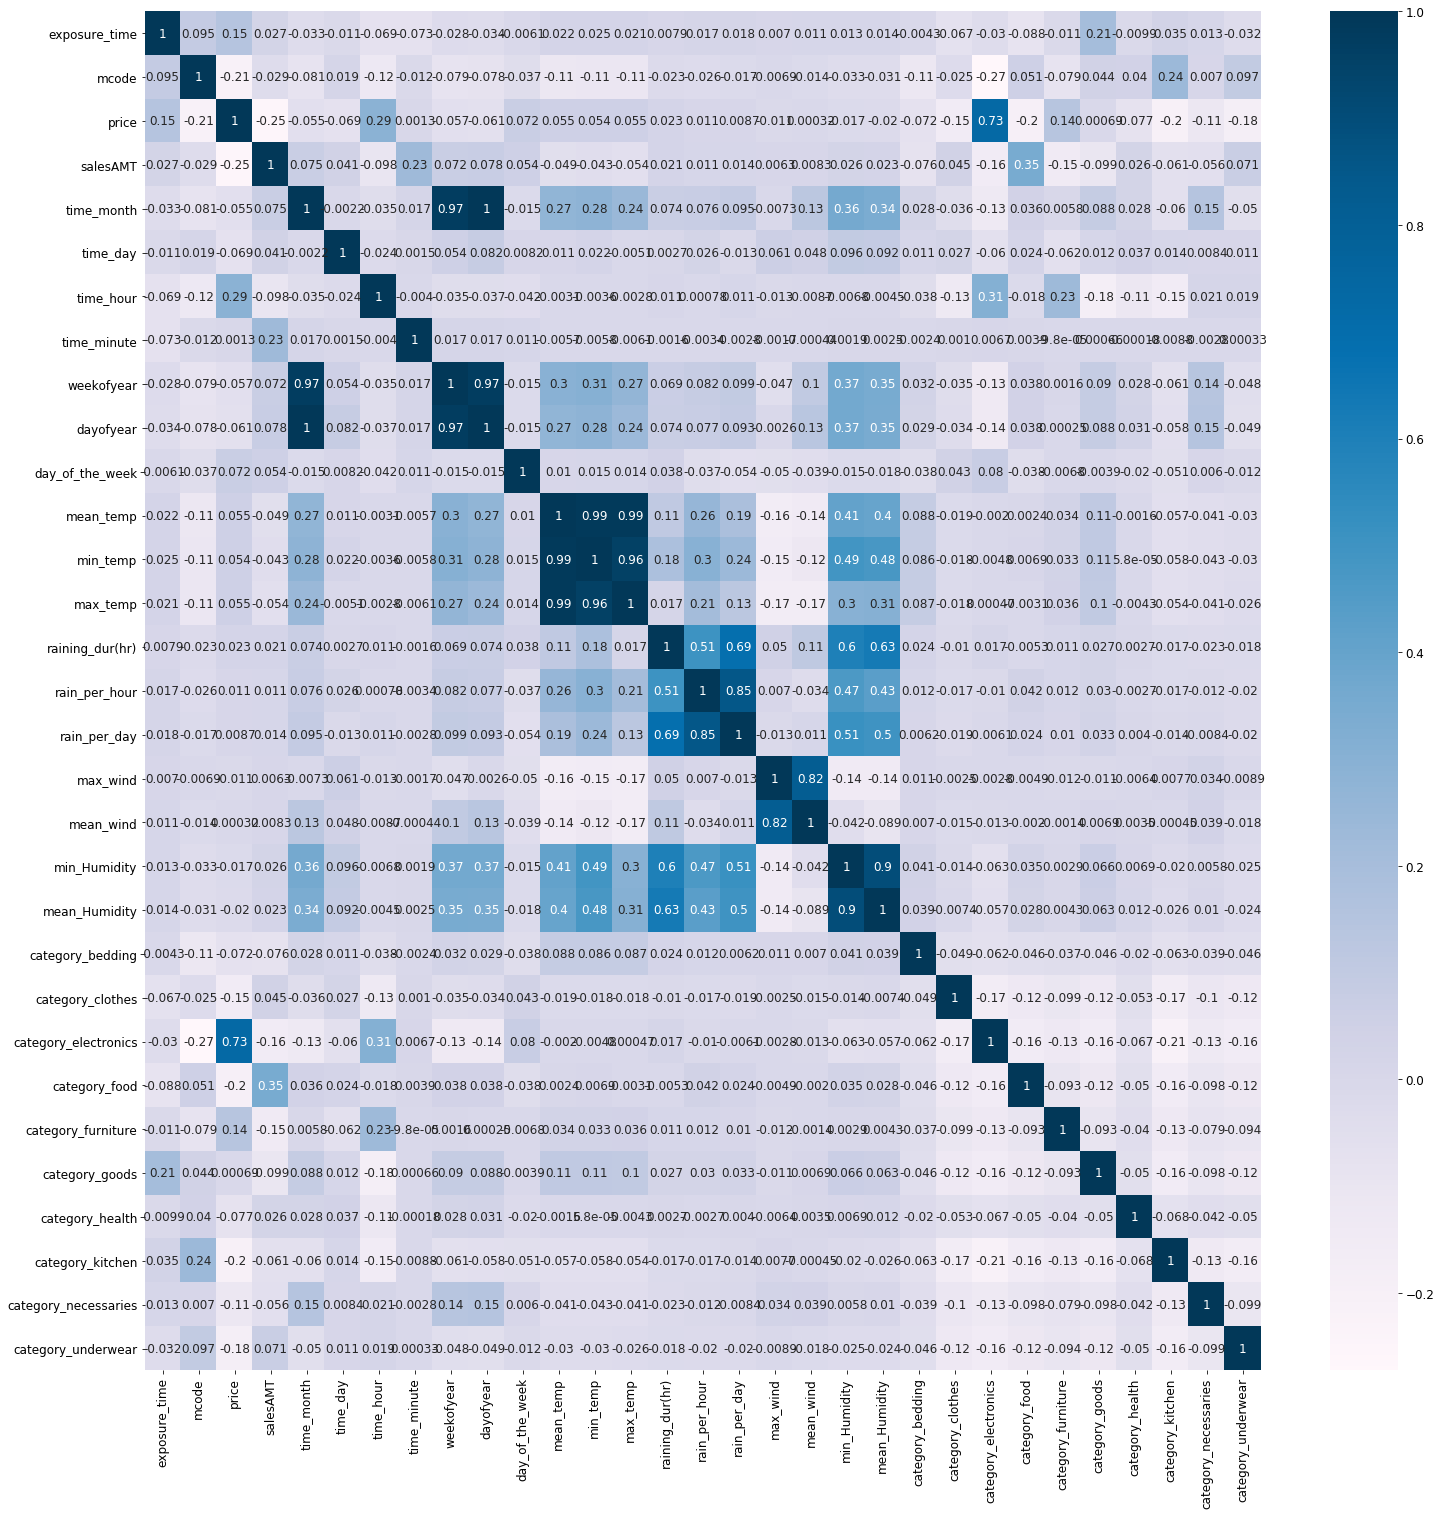

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(25,25))
sns.heatmap(data_dummy.corr(), annot=True, cmap='PuBu')
plt.show()

* 상관관계 높은 유사 변수 제거 필요

# ML model

## Define MAPE

In [15]:
def MAPE(y_true, y_pred): 

    return np.mean(np.abs((y_pred-y_true) / y_true)) * 100

## RF

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

### Validation Data

In [17]:
data_dummy

,exposure_time,mcode,price,salesAMT,time_month,time_day,time_hour,time_minute,weekofyear,dayofyear,day_of_the_week,date_x,mean_temp,min_temp,max_temp,raining_dur(hr),rain_per_hour,rain_per_day,max_wind,mean_wind,min_Humidity,mean_Humidity,date_y,category_bedding,category_clothes,category_electronics,category_food,category_furniture,category_goods,category_health,category_kitchen,category_necessaries,category_underwear
0,20.0,100346,39900,2099000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
1,20.0,100346,39900,4371000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
2,20.0,100346,39900,3262000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
3,20.0,100346,39900,6955000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
4,20.0,100346,39900,6672000.0,1,1,6,40,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,20.0,100448,148000,10157000.0,12,31,23,40,1,365,1,2019-12-31,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0
37368,20.0,100448,178000,50929000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0
37369,20.0,100448,168000,104392000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0
37370,20.0,100448,158000,13765000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31,0,0,0,0,0,0,0,1,0,0


In [18]:
X = data_dummy[['exposure_time', 'mcode', 'price', 'time_month', 'time_day',
       'time_hour', 'time_minute','weekofyear', 'dayofyear',
       'day_of_the_week', 'max_temp',
       'raining_dur(hr)', 'rain_per_hour', 'rain_per_day', 'max_wind','min_Humidity',
       'category_bedding', 'category_clothes', 'category_electronics',
       'category_food', 'category_furniture', 'category_goods',
       'category_health', 'category_kitchen', 'category_necessaries',
       'category_underwear', 'halbu', 'pay_1']]

y = data_dummy['salesAMT']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 777)

KeyError: "['pay_1', 'halbu'] not in index"

### Model

In [ ]:
rfc = RandomForestRegressor(random_state = 777)


param ={
    'n_estimators'      : [1000,500,100],
    'max_depth'         : [20,40],
    'min_samples_leaf'  : [4,2,1],
    'min_samples_split' : [2,4,6],
    'bootstrap' : [True]
}

grid_rfc = GridSearchCV(rfc, param_grid = param)

grid_rfc.fit(X_train, y_train)

print('최적 파라미터      : ', grid_rfc.best_params_)
print('최고 예측 정확도   : {0:.4f}'.format(grid_rfc.best_score_))

estimator = grid_rfc.best_estimator_

pred = estimator.predict(X_test)
print('검증 데이터 정확도 : {0:.4f}'.format(r2_score(y_test, pred)))

### MAPE

In [ ]:
MAPE(y_test, pred)

### Feature importance

In [ ]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#피처 중요도 도표 그리기
featureImportance = estimator.feature_importances_
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance[:])
barPos = np.arange(sorted_idx[:].shape[0])+ .5
plot.barh(barPos, featureImportance[sorted_idx[:]], align='center')
plot.yticks(barPos, X_train.keys()[sorted_idx][:])
plot.xlabel('Variable Importance')
plot.show()

In [ ]:
X_train.keys()[sorted_idx][:]

## LGBM

### Model

In [ ]:
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=777, n_estimators=1000,max_depth = -1,learning_rate = 0.1,lambda_l1 = 0.1, 
                          lambda_l2 = 0.1,num_iterations = 1500)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
model_score = MAPE(y_test, predicted)

### MAPE score

In [ ]:
model_score

### Feature importance

In [ ]:
featureImportance = model.feature_importances_
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance[:25])
barPos = np.arange(sorted_idx[:].shape[0])+ .5
plot.barh(barPos, featureImportance[sorted_idx[:]], align='center')
plot.yticks(barPos, X_train.keys()[sorted_idx][:])
plot.xlabel('Variable Importance')
plot.show()

# 자연어 처리

## 단어 빈도수 조사

In [19]:
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Twitter

def twitter_tokenizer(x):
    return twitter.nouns(x)

twitter = Twitter()

C:\Users\cjswo\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [20]:
sentences = list(data['product_name'])

In [21]:
def create_BOW(sentence,bow):
    words = sentence.split(" ")
    words = [i for i in words if i != ""]
    for word in words:
        if word == "":
            pass
        try : bow[word] += 1
        except : bow[word] = 1
    
    return bow

In [22]:
bow = {}
for s in sentences:
    create_BOW(s,bow)

In [23]:
bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
bow_sorted[:20]

[('무이자', 5657),
 ('일시불', 5636),
 ('LG', 3792),
 ('TV', 3176),
 ('울트라HD', 2618),
 ('남성', 1604),
 ('쿠쿠전기밥솥', 1507),
 ('여성', 1347),
 ('삼성', 1340),
 ('침대', 1206),
 ('3종', 1197),
 ('쿠첸', 1178),
 ('압력밥솥', 1172),
 ('LED', 1170),
 ('패키지', 1156),
 ('6인용', 1148),
 ('푸마', 1016),
 ('세트', 803),
 ('유로탑', 792),
 ('보루네오', 787)]

In [24]:
bow_df = pd.DataFrame(bow.values(), index = bow.keys())
bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

bow_df['word freq'] = bow_df[0]

bow_df.drop(0, axis = 1, inplace = True)

bow_df['freq rate(%)'] = bow_df['word freq']*100/len(data)
print(bow_df['word freq'].sum())
bow_df.head(20)

167399


,word freq,freq rate(%)
무이자,5657,15.137001
일시불,5636,15.080809
LG,3792,10.146634
TV,3176,8.498341
울트라HD,2618,7.005245
남성,1604,4.291983
쿠쿠전기밥솥,1507,4.032431
여성,1347,3.604303
삼성,1340,3.585572
침대,1206,3.227015


* 무이자 일시불 비율 약 30% -> feature로 사용가능성 o

## 무이자 일시불 취급액 차이 비교

In [25]:
index_m2 = []
for i in range(len(data)):
    if data['product_name'].iloc[i].split(" ")[0] == '무이자':
        index_m2.append(i)
        
index_1 = []
for i in range(len(data)):
    if data['product_name'].iloc[i].split(" ")[0] == '일시불':
        index_1.append(i)

In [26]:
df_m2 = data.iloc[index_m2]
df_1 = data.iloc[index_1]

In [27]:
print('무이자 평균 취급액 : ',df_m2['salesAMT'].mean())
print('일시불 평균 취급액 : ',df_1['salesAMT'].mean())
print('전체 평균 취급액 : ',data['salesAMT'].mean())

무이자 평균 취급액 :  13390508.272549368
일시불 평균 취급액 :  15366883.392857144
전체 평균 취급액 :  21873054.318741303


In [28]:
df_1['salesAMT'].mean()/df_m2['salesAMT'].mean()

1.1475952279092614

* 일시불 상품이 무이자 상품보다 약 15% 정도 평균 취급액 높음

In [29]:
data_dummy['halbu'] = 0
data_dummy['halbu'][index_m2] = 1

data_dummy['pay_1'] = 0
data_dummy['pay_1'][index_1] = 1

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [30]:
data_dummy.columns

Index(['exposure_time', 'mcode', 'price', 'salesAMT', 'time_month', 'time_day',
       'time_hour', 'time_minute', 'weekofyear', 'dayofyear',
       'day_of_the_week', 'date_x', 'mean_temp', 'min_temp', 'max_temp',
       'raining_dur(hr)', 'rain_per_hour', 'rain_per_day', 'max_wind',
       'mean_wind', 'min_Humidity', 'mean_Humidity', 'date_y',
       'category_bedding', 'category_clothes', 'category_electronics',
       'category_food', 'category_furniture', 'category_goods',
       'category_health', 'category_kitchen', 'category_necessaries',
       'category_underwear', 'halbu', 'pay_1'],
      dtype='object')

## 카테고리 별 최다 빈도 단어 분석

In [50]:
category_list = ['category_bedding', 'category_clothes', 'category_electronics',
       'category_food', 'category_furniture', 'category_goods',
       'category_health', 'category_kitchen', 'category_necessaries',
       'category_underwear']

In [51]:
for l in category_list:
    sentences = list(data[data_dummy[l]== 1]['product_name'])

    bow = {}
    for s in sentences:
        create_BOW(s,bow)
    
    bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
    print(l,'\n')
    
    bow_df = pd.DataFrame(bow.values(), index = bow.keys())
    bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

    bow_df['word freq'] = bow_df[0]

    bow_df.drop(0, axis = 1, inplace = True)

    bow_df['freq rate(%)'] = bow_df['word freq']*100/len(data[data_dummy[l]== 1])
    print(bow_df.head(15),'\n'*3)

category_bedding 

         word freq  freq rate(%)
보몽드            543     81.165919
침구세트           531     79.372197
시어서커           372     55.605381
리플             252     37.668161
샐비어            252     37.668161
자수             177     26.457399
SS             123     18.385650
Q              123     18.385650
K              123     18.385650
엘사             120     17.937220
쿨              120     17.937220
SK(슈퍼킹)         66      9.865471
토퍼침구세트          60      8.968610
더블착번극세사         60      8.968610
카밀라             60      8.968610 



category_clothes 

         word freq  freq rate(%)
남성            1168     26.912442
여성             871     20.069124
3종             852     19.631336
썸머             416      9.585253
뱅뱅             413      9.516129
4종             310      7.142857
K-SWISS        308      7.096774
19             289      6.658986
마르엘라로사티        277      6.382488
2종             271      6.244240
데님팬츠           270      6.221198
NNF            246      5.668203
헤

### 테스트셋 카테고리도 뽑아보기


In [55]:
test_data = pd.read_excel('./Data/test.xlsx', encoding='cp949', header=1, parse_dates=["방송일시"])

In [56]:
test_data 

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2887,2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2888,2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN


In [59]:
#무형제거
test_data.drop(test_data[test_data['상품군']=='무형'].index, inplace=True)
test_data.reset_index(inplace=True)

In [60]:
test_data 

,index,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
1,1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
2,2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
3,3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
4,4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
...,...,...,...,...,...,...,...,...,...
2711,2883,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,NaN
2712,2884,2020-07-01 00:10:00,10.000000,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,NaN
2713,2885,2020-07-01 00:10:00,10.000000,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,NaN
2714,2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN


In [61]:
test_data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']

In [69]:
# 카테고리명 영어로 변경
test_data.loc[test_data["category"] == "의류", "category"] = "clothes"
test_data.loc[test_data["category"] == "속옷", "category"] = "underwear"
test_data.loc[test_data["category"] == "주방", "category"] = "kitchen"
test_data.loc[test_data["category"] == "농수축", "category"] = "food"
test_data.loc[test_data["category"] == "이미용", "category"] = "beauty"
test_data.loc[test_data["category"] == "가전", "category"] = "electronics"
test_data.loc[test_data["category"] == "생활용품", "category"] = "necessaries"
test_data.loc[test_data["category"] == "건강기능", "category"] = "health"
test_data.loc[test_data["category"] == "잡화", "category"] = "goods"
test_data.loc[test_data["category"] == "가구", "category"] = "furniture"
test_data.loc[test_data["category"] == "침구", "category"] = "bedding"

# 상품군 one-hot encoding
test_data_dummy = pd.get_dummies(test_data, columns=['category'], prefix='category', drop_first=True)
test_data_dummy.drop(columns=['index','time','product_name','product_code'],inplace=True)

In [83]:
# test set 카테고리별 단어추출
for l in category_list:
    sentences = list(test_data[test_data_dummy[l]== 1]['product_name'])

    bow = {}
    for s in sentences:
        create_BOW(s,bow)
    
    bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
    print('test_set ',l,'\n')
    
    bow_df = pd.DataFrame(bow.values(), index = bow.keys())
    bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

    bow_df['word freq'] = bow_df[0]

    bow_df.drop(0, axis = 1, inplace = True)

    bow_df['freq rate(%)'] = bow_df['word freq']*100/len(test_data[test_data_dummy[l]== 1])
    print(bow_df.head(40),'\n'*3)
    
    
    # train set 6월
    sentences = list(data[data_dummy[l]== 1]['product_name'])

    bow = {}
    for s in sentences:
        create_BOW(s,bow)
    
    bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
    print('train_set ',l,'\n')
    
    bow_df = pd.DataFrame(bow.values(), index = bow.keys())
    bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

    bow_df['word freq'] = bow_df[0]

    bow_df.drop(0, axis = 1, inplace = True)

    bow_df['freq rate(%)'] = bow_df['word freq']*100/len(data[data_dummy[l]== 1])
    print(bow_df.head(40),'\n'*3)
    

        
    # train set 6월
    sentences = list(data[data['time_month'] == 6][data_dummy[l] == 1]['product_name'])

    bow = {}
    for s in sentences:
        create_BOW(s,bow)
    
    bow_sorted = sorted(bow.items(), key=lambda x: x[1], reverse=True)
    print('train_set 6월 ',l,'\n')
    
    bow_df = pd.DataFrame(bow.values(), index = bow.keys())
    bow_df.sort_values(0,axis = 0, inplace = True, ascending = False)

    bow_df['word freq'] = bow_df[0]

    bow_df.drop(0, axis = 1, inplace = True)

    bow_df['freq rate(%)'] = bow_df['word freq']*100/len(data[data['time_month'] == 6][data_dummy[l] == 1]['product_name'])
    print(bow_df.head(40),'\n'*3)
    

test_set  category_bedding 

             word freq  freq rate(%)
암막                  48     66.666667
지나송                 36     50.000000
웨딩스타일               24     33.333333
보몽드                 24     33.333333
실루엣                 24     33.333333
쿨시어서커               24     33.333333
침구                  24     33.333333
풀세트                 24     33.333333
로사                  24     33.333333
보노                  12     16.666667
이중                  12     16.666667
샤를                  12     16.666667
한스데코                12     16.666667
화이트에디션              12     16.666667
레이스                 12     16.666667
Q(퀸)                 6      8.333333
SS(슈퍼싱글)             6      8.333333
K(킹)                 6      8.333333
이중커튼(슈퍼특대형)          6      8.333333
커튼(중형)               6      8.333333
커튼(대형)               6      8.333333
커튼(특대형)              6      8.333333
커튼(슈퍼특대형)            6      8.333333
이중커튼(특대형)            6      8.333333
이중커튼(대형)             6      8.333333
이중커튼(중형) 

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 category_clothes 

         word freq  freq rate(%)
남성            1168     26.912442
여성             871     20.069124
3종             852     19.631336
썸머             416      9.585253
뱅뱅             413      9.516129
4종             310      7.142857
K-SWISS        308      7.096774
19             289      6.658986
마르엘라로사티        277      6.382488
2종             271      6.244240
데님팬츠           270      6.221198
NNF            246      5.668203
헤스티지           244      5.622120
PAT            242      5.576037
by             242      5.576037
CERINI         242      5.576037
F/W            226      5.207373
임페리얼           207      4.769585
S/S)           204      4.700461
보코             200      4.608295
롱코트            196      4.516129
컬렉션            192      4.423963
밍크             188      4.331797
USPA           186      4.285714
그렉노먼           175      4.032258
폴로셔츠           171      3.940092
니트             171      3.940092
5종             168      3.870968
크리스티나앤코        167     

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 



train_set 6월  category_electronics 

                word freq  freq rate(%)
LG                    334     63.018868
일시불                   265     50.000000
무이자                   261     49.245283
울트라HD                 176     33.207547
TV                    176     33.207547
벽걸이에어컨                160     30.188679
캐리어                   160     30.188679
에어컨                   138     26.037736
휘센                    124     23.396226
씽큐                    108     20.377358
6형                     80     15.094340
ARC06NQT               80     15.094340
7형                     80     15.094340
ARC07VBC               80     15.094340
2IN1형                  62     11.698113
FQ17V9KWA2             46      8.679245
스탠드형FQ17V9KWA1         46      8.679245
75UK6200KNB            44      8.301887
65UK6800HNC            44      8.301887
55UK6800HNC            44      8.301887
70UK7400KNA            44      8.301887
통돌이                    34      6.415094
세탁기                    34      6.41509

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


                word freq  freq rate(%)
8팩                     75     37.688442
AAB의                   36     18.090452
소곱창전골                  36     18.090452
800g                   36     18.090452
x                      36     18.090452
국내산                    33     16.582915
손질갑오징어                 33     16.582915
유귀열의                   33     16.582915
귀한                     33     16.582915
자연산                    30     15.075377
갓김치3kg+총각김치3kg         27     13.567839
(총6kg)                 27     13.567839
사용불가미리구운               21     10.552764
바다장어                   21     10.552764
9팩                     21     10.552764
20kg                   20     10.050251
쌀                      20     10.050251
흥양농협                   20     10.050251
멋진밥상                   20     10.050251
안동간고등어                 15      7.537688
20팩                    15      7.537688
손질                      9      4.522613
10팩                     9      4.522613
통오징어                    9      4.522613


C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 category_goods 

        word freq  freq rate(%)
[루이띠에]        406     10.434336
프라다           399     10.254433
소가죽           365      9.380622
코치            360      9.252120
여성            351      9.020817
남성            311      7.992804
삭루츠           279      7.170393
2종            276      7.093292
월드컵           272      6.990491
18K           236      6.065279
베르니아          224      5.756875
크로스백          215      5.525572
숄더백           211      5.422770
토트백           207      5.319969
다이아몬드         198      5.088666
도스문도스         195      5.011565
세트            192      4.934464
선글라스          185      4.754562
카이만           183      4.703161
팔찌            183      4.703161
엠보            183      4.703161
2019          183      4.703161
목걸이           165      4.240555
1종            147      3.777949
아가타           141      3.623747
18k           140      3.598047
순금            140      3.598047
3종            124      3.186841
칼리베이직         123      3.161141
사첼백           123     

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 



train_set  category_kitchen 

                      word freq  freq rate(%)
일시불                        1958     29.648698
무이자                        1953     29.572986
쿠쿠전기밥솥                     1507     22.819503
쿠첸                         1178     17.837674
압력밥솥                       1172     17.746820
6인용                         926     14.021805
10인용                        761     11.523319
풀스텐                         740     11.205330
대용량                         533      8.070866
10인용(A1)                    509      7.707450
(A1)                        495      7.495457
스텐                          488      7.389461
자동불꽃조절                      444      6.723198
가스레인지                       444      6.723198
린나이                         444      6.723198
19년                         432      6.541490
신제품                         432      6.541490
한일                          401      6.072078
분쇄믹서기                       401      6.072078
올리고                         390      5.905512

C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\cjswo\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


                    word freq  freq rate(%)
라이크라                       65     17.333333
패키지                        64     17.066667
푸마                         63     16.800000
드로즈                        62     16.533333
브라팬티                       56     14.933333
아키                         53     14.133333
파이로라이트                     46     12.266667
10종                        46     12.266667
헤드                         46     12.266667
레이스                        45     12.000000
DRY-CELL                   45     12.000000
7세트(14종)                   45     12.000000
풍기인견                       45     12.000000
풀컵                         45     12.000000
오모떼                        45     12.000000
와이드                        45     12.000000
풀커버                        42     11.200000
패키지(106차)(랜덤2세트추가)         39     10.400000
10+4종                      36      9.600000
8종                         34      9.066667
초특가)에버라스트                  30      8.000000
레이프릴                       30   

,index,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,time_month,time_day,time_hour,time_minute,weekofyear,dayofyear,day_of_the_week,date_x,mean_temp,min_temp,max_temp,raining_dur(hr),rain_per_hour,rain_per_day,max_wind,mean_wind,min_Humidity,mean_Humidity,date_y
0,0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,2099000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
1,1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,4371000.0,1,1,6,0,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
2,2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,3262000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
3,3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,6955000.0,1,1,6,20,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
4,4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,6672000.0,1,1,6,40,1,1,1,2019-01-01,-5.0,-8.2,-0.6,0.00,0.0,0.0,4.3,2.1,34,49.5,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,38299,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,kitchen,148000,10157000.0,12,31,23,40,1,365,1,2019-12-31,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
37368,38300,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,kitchen,178000,50929000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
37369,38301,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,kitchen,168000,104392000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
37370,38302,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,kitchen,158000,13765000.0,12,31,24,0,1,365,1,2020-01-01,-7.9,-10.9,-4.5,1.58,0.0,0.0,7.5,3.1,26,39.3,2019-12-31
